<a href="https://colab.research.google.com/github/GastonMazzei/cnn-colab/blob/main/all-together-for-collab-vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Imports
import cv2
import pickle
import sys
import os

import numpy as np
import pandas as pd

from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.optimizers import SGD
from keras import models
from keras import layers

from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler
from PIL import Image
from math import ceil,floor
from random import choice

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Image size
SIDE = 40

In [12]:

def main(img, rows, cols, angle, scaling):

  # ROTATE
  M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
  new = cv2.warpAffine(img,M,(cols,rows))

  # RESCALE by s
  # shrinking uses  cv2.INTER_AREA 
  # zooming uses cv2.INTER_CUBIC (slow) OR cv2.INTER_LINEAR
  #
  slow = False
  if slow: zoom_inter = cv2.INTER_CUBIC
  else: zoom_inter = cv2.INTER_LINEAR
  if scaling<1:
    new = cv2.resize(new,(0,0),fx=scaling, fy=scaling, interpolation = cv2.INTER_AREA)
    temp_rows, temp_cols = new.shape
    if (rows-temp_rows)%2==0:
      top,bottom = [(rows-temp_rows)//2]*2
    else:
      top,bottom = floor((rows-temp_rows)/2), ceil((rows-temp_rows)/2) 
    if (cols-temp_cols)%2==0:
      left,right = [(cols-temp_cols)//2]*2
    else:
      left,right = floor((cols-temp_cols)/2), ceil((cols-temp_cols)/2) 
    new = cv2.copyMakeBorder(new,top, bottom, left, right,  cv2.BORDER_CONSTANT, value=0)
  elif scaling>1:
    new = cv2.resize(new,(0,0),fx=scaling, fy=scaling, interpolation = zoom_inter)
    temp_rows, temp_cols = new.shape
    new = new[(temp_rows-rows)//2:(temp_rows+rows)//2, (temp_cols-cols)//2:(temp_cols+cols)//2]
    new = cv2.resize(new,(rows,cols), interpolation = cv2.INTER_AREA)

  return new

# preprocessing functions
def preprocess(data, **kwargs):
    s = MinMaxScaler().fit(data['train'][1])
    if False: pass
    else:
      result = {}
      try: a,b,c = data['test'][0][0].shape
      except: c=0 
      if c>1:
        def op_1(q):
          q=np.mean(q,2).reshape(SIDE,SIDE,1)        
          #return np.rint(q/255)
          return q/255
      elif c==1:
        def op_1(q):
          #return np.rint(q/255)
          return q/255
      else:
        def op_1(q):
          #return np.rint(q/255).reshape(SIDE,SIDE,1)
          return q.reshape(SIDE,SIDE,1)/255

      for x in data.keys():
        print(data[x][1].shape)
        if True:
          print(f'Y pair for key {x} max,min were: \n{np.max(data[x][1],0)}'\
                f', {np.min(data[x][1],0)}\n{np.max(data[x][1],0)}, '\
                f'{np.min(data[x][1],0)}')
        if c==1: 
          print('c==1 has a speed improvement!')
          L,*_ = data[x][0].shape
          result[x] = (data[x][0].reshape(L,SIDE,SIDE,1)/255, s.transform(data[x][1]))
        else:
          result[x] = (np.asarray([op_1(y) for y in data[x][0]]) , 
                       s.transform(data[x][1]))
        if True:
          print(f'Y pair for key {x} max,min are: \n{np.max(result[x][1],0)}'\
                f', {np.min(result[x][1],0)}\n{np.max(result[x][1],0)}, '\
                f'{np.min(result[x][1],0)}')
      data['scaler'] = (s)

      small = {'test':(result['test'][0][:150], result['test'][1][:150])}
      with open('/content/drive/My Drive/ml-output/escher/small-test.pkl','wb') as f: pickle.dump(small,f)
      if sys.getsizeof(result)<2.5e9: 
        print('SAVING THE DATABASE!')
        with open('/content/drive/My Drive/ml-output/escher/whole-database.pkl','wb') as f: pickle.dump(result,f)      
      else: print('database size was (in bytes)', sys.getsizeof(result))

      return result


def first_one(N=30000):
  firstdir = os.getcwd()
  os.chdir('/content/drive/My Drive/nn-images')
  images = {name:cv2.imread(name,0) for name in os.listdir() if name[-3:] in ['png','jpg']}
  images_names = list(images.keys())
  os.chdir(firstdir)
  print(images_names)
  data = {'angle':[], 'scaling':[],
          'name':[],  'image':[],'source':[]}
  
  length = int((N/len(images_names))**(1/2))
  angles = np.linspace(-90,90,length)
  scalings = [round(2**x,3) for x in np.linspace(-1,1,length)]
  combinations = []
  lap = 0
  for _1 in images_names:
    for _2 in range(length):
      for _3 in range(length):
        combinations.append((angles[_2], scalings[_3], _1))
  for x in combinations:
    lap+=1
    if lap%10000==0: print('lap number is ',lap)

    angle = x[0]
    scaling = x[1]
    img_name = x[2]

    img = images[img_name]
    rows,cols = img.shape
    result = main(img, rows, cols, angle, scaling)
    data['angle'].append(angle)
    data['source'].append(img_name)
    data['scaling'].append(scaling)
    data['image'].append(result)
    name_index=0
    name = f'{angle}_{scaling}_{name_index}'
    while name in data['name']:
      name_index+=1
      name = f'{angle}_{scaling}_{name_index}'
    data['name'].append(name)
  return data
    

In [13]:
# The Neural Network core
def create_and_predict(data,**kwargs):
    """
    kwargs: 
        neurons=32
        epochs=50
        learning_rate=0.01
        batch_size=32
        plot=False
    """
    print('about to build network')
    #
    # 1) Initialize

    if False:
      def L0(ks=8,f=1,s=1, act=None, pd='valid'): 
        return  layers.Conv2D(
                          f, #filters
                          (ks,ks), #kernel size
                          strides=(s, s),
                          activation=act,
                          padding = pd,
                          input_shape=(SIDE, SIDE, 1),
                          )

      def L(ks=8,f=1,s=1, act=None, pd='same'):
        return  layers.Conv2D(
                          f, 
                          (ks,ks), 
                          strides=(s, s),
                          activation=act,
                          padding=pd,
                          )
      def MP0(ps=6, s=2):
        return  layers.MaxPooling2D(pool_size=(ps, ps), strides=s, 
                                )
      def MP():
        return  layers.MaxPooling2D(pool_size=(5, 5), strides=6, 
                                )

      TIMES = 3
      out=SIDE*SIDE
      model = models.Sequential()

      N = 6
      Ndense=3
      activ = 'relu'
      kernel_size = 12#5
      q = 40
      if True:
        # CONV 1
        model.add(L0(ks=5,f=1,s=1, act=None, pd='valid')) # dof= ks**2+1
        # POOL 1
        model.add(MP0(ps=5,s=2))
        # CONV 2-N
        for _ in range(N):
          model.add(L0(ks=kernel_size, f=1, s=1, act=activ, pd='same')) # dof= ks**2+1
        # POOL 2
        model.add(MP0(ps=5,s=2))

        # Flatten & Dense
        model.add(layers.Flatten()) 
        for _ in range(Ndense):
          model.add(Dense(
                q,#12,
                activation=activ))

    if False:
      # LeCunn
      model = models.Sequential()

      model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(40,40,1)))
      model.add(layers.AveragePooling2D())

      model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
      model.add(layers.AveragePooling2D())

      model.add(layers.Flatten())

      model.add(layers.Dense(units=40, activation='relu'))

      model.add(layers.Dense(units=20, activation='relu'))

      #model.add(layers.Dense(units=10, activation = 'softmax'))

    if True:
      # VGG16
      input_shape = (40,40,1)#(224,224,3)
      dense_neurons = 100 #4096=64^2
      f_s,f_m,f_l,f_xl = 4,8,16,32 #10, 20,40, 80 #64, 128,256, 512
      ks_big = (3,3) #(3,3)
      ks_small = (2,2)
      model = Sequential()

      model.add(Conv2D(input_shape=input_shape,
                      filters=f_s,kernel_size=ks_big,padding="same", activation="relu"))

      model.add(Conv2D(filters=f_s,kernel_size=ks_big,padding="same", activation="relu"))

      model.add(MaxPool2D(pool_size=(2,2),strides=ks_small))

      #model.add(Conv2D(filters=f_m, kernel_size=ks_big, padding="same", activation="relu")) #mutted 1 of 3 convs

      model.add(Conv2D(filters=f_m, kernel_size=ks_big, padding="same", activation="relu"))

      model.add(MaxPool2D(pool_size=(2,2),strides=ks_small))

      #model.add(Conv2D(filters=f_l, kernel_size=ks_big, padding="same", activation="relu"))#mutted 1 of 3 convs

      model.add(Conv2D(filters=f_l, kernel_size=ks_big, padding="same", activation="relu"))

      model.add(Conv2D(filters=f_l, kernel_size=ks_big, padding="same", activation="relu"))

      model.add(MaxPool2D(pool_size=(2,2),strides=ks_small))

      #model.add(Conv2D(filters=f_xl, kernel_size=ks_big, padding="same", activation="relu"))#mutted 1 of 3 convs

      model.add(Conv2D(filters=f_xl, kernel_size=ks_big, padding="same", activation="relu"))

      model.add(Conv2D(filters=f_xl, kernel_size=ks_big, padding="same", activation="relu"))

      model.add(MaxPool2D(pool_size=(2,2),strides=ks_small))

      #model.add(Conv2D(filters=f_xl, kernel_size=ks_big, padding="same", activation="relu"))#mutted last step because it was already 2!

      #model.add(Conv2D(filters=f_xl, kernel_size=ks_big, padding="same", activation="relu"))

      #model.add(Conv2D(filters=f_xl, kernel_size=ks_big, padding="same", activation="relu"))

      #model.add(MaxPool2D(pool_size=(2,2),strides=ks_small))

      model.add(Flatten())
      model.add(Dense(units=dense_neurons,activation="relu"))
      model.add(Dense(units=dense_neurons,activation="relu"))


    mode = ['classifier', 'regressor'][1]
    if mode=='classifier':  
      model.add(Dense(
              out,
              activation='sigmoid'))

      model.compile(
              optimizer=SGD(learning_rate=kwargs.get('learning_rate',.001)),
              loss='binary_crossentropy',
              metrics='accuracy',)     
    else:  
      model.add(Dense(
              2,
              activation='linear'))

      model.compile(
              optimizer=SGD(learning_rate=kwargs.get('learning_rate',.02)),
              loss='mean_squared_error',
              metrics='accuracy',)     

    #
    # 2) Fit
    print(model.summary())
    print(f'training set is shaped: {data["train"][0].shape} and the first dim is the # of samples')
    print('about to train')
    results = model.fit(
            *data['train'],
            batch_size=kwargs.get('batch_size',256),
            epochs=kwargs.get('epochs',50),
            verbose=1,
            validation_data=data['val'],)
    model.save(f'/content/drive/My Drive/ml-output/escher/model')

    #
    # 3) Return results
    results = results.history 
    results['ytrue_val'] = data['val'][1]
    results['ytrue_test'] = data['test'][1]
    results['ypred_val'] = model.predict(data['val'][0])
    results['ypred_test'] = model.predict(data['test'][0])
    results['specs'] = kwargs
    important_results = {'ytrue_test':results['ytrue_test'],
                         'ypred_test':results['ypred_test']}
    with open('/content/drive/My Drive/ml-output/escher/results.pkl','wb') as w:
      pickle.dump(important_results,w)
 
    #
    # 4) Maybe, plot
    if kwargs.get('plot',False):
        regression = True
        case = 'val'
        if not regression:
          f, ax = plt.subplots(1,3)
          fpr, tpr, treshold = roc_curve(
                results['ytrue_'+case], results['ypred_'+case]
                    )
          ax[0].plot(fpr, tpr)
        
          weights = {0:[],1:[]}
          for i,x in enumerate(results['ypred_'+case]):
            weights[data[case][1][i][0]] += [x[0]]

       
          ax[1].hist(weights[0],label='0',alpha=0.5)
          ax[1].hist(weights[1],label='1',alpha=0.5)
          ax[1].set_xlim(0,1)
          ax[1].legend()

          ax[2].plot(results['accuracy'],c='b',label='train')
          ax[2].plot(results['val_accuracy'],c='g')
          ax[2].plot(results['loss'],c='b')
          ax[2].plot(results['val_loss'],c='g',label='validation')
          ax[2].legend()
          ax[2].set_ylim(0,1)

        else:
          plt.plot(results['accuracy'],c='b',label='train')
          plt.plot(results['val_accuracy'],c='g')
          plt.plot(results['loss'],c='b')
          plt.plot(results['val_loss'],c='g',label='validation')
          plt.legend()

        plt.savefig('/content/drive/My Drive/ml-output/escher/training_curve.png')
        if False:
            plt.plot(
                *roc_curve(
                    results['ytrue_test'], results['ypred_test']
                        )[:-1])
    return results

In [14]:
# The database builder, step zero before preprocessing, that makes a 250M file from the 25M database in drive
def build_database(data):
  from sklearn.model_selection import train_test_split
  L = len(data['angle'])
  for x in ['angle','scaling']: data[x] = np.asarray(data[x]).reshape(-1,1)
  X,y = data['image'], np.concatenate([data['angle'], data['scaling']],1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=420)

  data = {'train':(X_train, y_train),
          'val':(X_val, y_val),
          'test':(X_test, y_test),}
  return data

about to preprocess
ended preprocessing!
about to build network
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 4)         40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 4)         148       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 8)         296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        1168      
__________________________________________________________

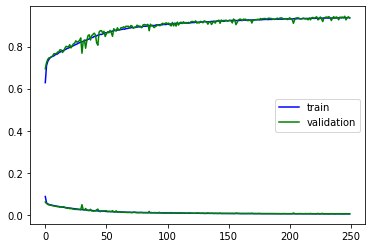

In [15]:
if True:
   
    mode = 'cnn'
    switch = {1:[True, False][1],
              2:[True, False][1],
              3:[True, False][0],}


    if switch[3]:
      from keras.backend import clear_session
      clear_session()
      print('about to preprocess')
      #dat = preprocess(build_database(first_one(140000)), mode=mode.upper())
      with open('/content/drive/My Drive/ml-output/escher/whole-database.pkl','rb') as f: dat=pickle.load(f)      
      print('ended preprocessing!')
      create_and_predict(dat,
              epochs=250,plot=True,learning_rate=0.01, mode=mode.upper())


In [16]:
jsfunc="""
function ClickConnect(){
  colab.config
  console.log("Connnect Clicked - Start"); 
  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
  console.log("Connnect Clicked - End");
};
setInterval(ClickConnect, 1000000)
"""